In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from agents import *
from environment import *

In [55]:
DISCOUNT = 0.6
EPSILON = 0.9

In [56]:
print(f"Discount: {DISCOUNT}. Epsilon: {EPSILON}")

Discount: 0.6. Epsilon: 0.9


In [4]:
def plot_heat_maps(value_array, policy_array, reward, penalty):
    _, axes = plt.subplots(2, 1, figsize=(15, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    matplotlib.rcParams.update({'font.size': 22})
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

    axes = axes.flatten()
    axes[0].set_title(
        f'Value Function -- Reward: {reward} Penalty: {penalty} Discount: {DISCOUNT}', 
        fontsize=20
    )

    fig = sns.heatmap(
    #     np.flipud(results), 
        value_array,
        cmap="YlGnBu", 
        ax=axes[0],
    )
    fig.set_ylabel('# Old Vaccines ', fontsize=20)
    fig.set_xlabel('# New Vaccines ', fontsize=20)

    
    axes[1].set_title(
        f'Policy -- Reward: {reward} Penalty: {penalty} Discount: {DISCOUNT}', 
        fontsize=20
    )

    fig = sns.heatmap(
    #     np.flipud(results), 
        policy_array,
        cmap="YlGnBu", 
        ax=axes[1]
    )
    fig.set_ylabel('# Old Vaccines ', fontsize=20)
    fig.set_xlabel('# New Vaccines ', fontsize=20)
    


## Bellman Solution

In [5]:
centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
agent = bellman_agent(max_vax=15,max_delivery=15)

iteration = 0
while not agent.is_policy_stable:
    #if iteration % 10 == 0:
    print(f"Iteration: {iteration}")
    agent.policy_evaluation(centre, dist, verbose=False)
    agent.policy_improvement(centre, dist, verbose=False)
    iteration += 1

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2020-12-30 16:44:15,657 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-30 16:44:15,657 - INFO - NumExpr defaulting to 8 threads.


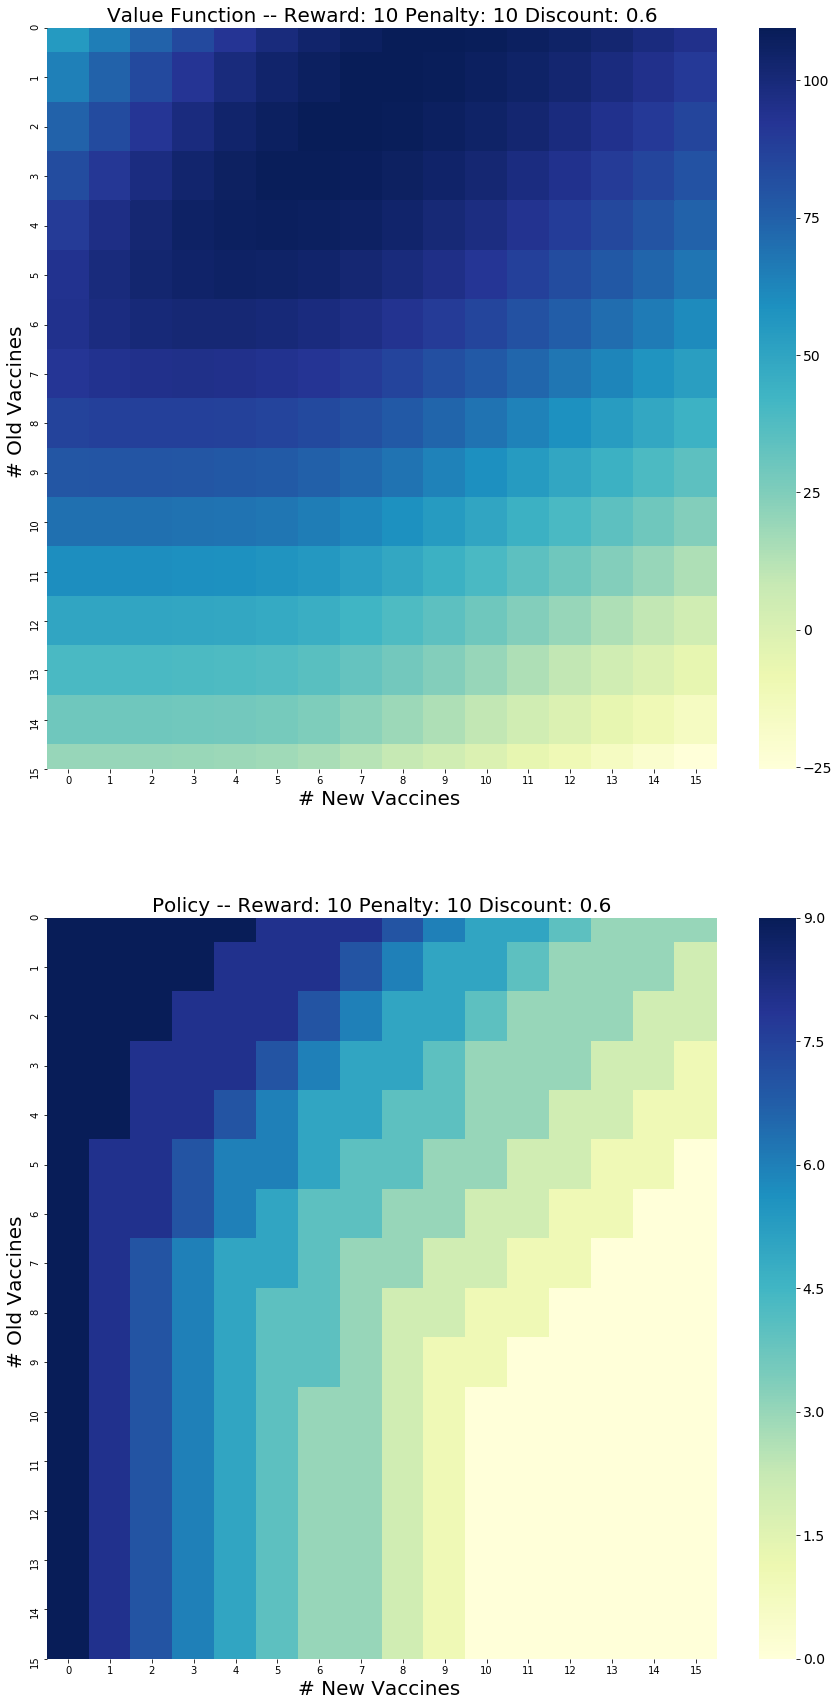

In [6]:
plot_heat_maps(agent.V, agent.policy, centre.fee_vaccine, centre.cost_vaccine)

## Model Free Solution

In [58]:
def epsilon_greedy(q_vec, curr_iter, no_decay_iters, epsilon=EPSILON, decay=False):
    """
    Returns the index of the action selected under an epsilon
    greedy policy
    """

    # adjust epsilon if required
    if decay == True and curr_iter > no_decay_iters:
            epsilon = epsilon / (curr_iter - no_decay_iters)

    
    # behave epsilon greedily
    if epsilon < np.random.random():
        return np.argmax(q_vec)
    else:
        return np.random.randint(np.array(q_vec).shape[-1])

In [59]:
def QLearning_policy(q_vec, action):
    """
    Identifies the action which maximises the q_vec
    state-action vector and returns a policy with all
    weight centred on highest value return
    """
    return np.eye(len(q_vec))[np.argmax(q_vec)]


def sarsa_policy(q_vec, action):
    """
    """
    return np.eye(len(q_vec))[action]


def expected_sarsa_policy(q_vec, action, epsilon=EPSILON):
    """
    """
    greedy = QLearning_policy(q_vec, action)
    return greedy - greedy * epsilon + epsilon / len(q_vec)

## Q-Learning

In [32]:
%%time

total_iters = 1000000
no_decay_iters = 200000
decay=True

q_learning_alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
    q_learning_agent = tabular_model_free_agent(
        max_vax=12,
        max_delivery=10,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=QLearning_policy
    )
    rewards = []
#     results = []
    for i in range(total_iters):
        if (i+1) % 100000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = q_learning_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    q_learning_alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 500000
Alpha: 0.05. Iteration: 600000
Alpha: 0.05. Iteration: 700000
Alpha: 0.05. Iteration: 800000
Alpha: 0.05. Iteration: 900000
Alpha: 0.05. Iteration: 1000000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 200000
Alpha: 0.1. Iteration: 300000
Alpha: 0.1. Iteration: 400000
Alpha: 0.1. Iteration: 500000
Alpha: 0.1. Iteration: 600000
Alpha: 0.1. Iteration: 700000
Alpha: 0.1. Iteration: 800000
Alpha: 0.1. Iteration: 900000
Alpha: 0.1. Iteration: 1000000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 200000
Alpha: 0.2. Iteration: 300000
Alpha: 0.2. Iteration: 400000
Alpha: 0.2. Iteration: 500000
Alpha: 0.2. Iteration: 600000
Alpha: 0.2. Iteration: 700000
Alpha: 0.2. Iteration: 800000
Alpha: 0.2. Iteration: 900000
Alpha: 0.2. Iterat

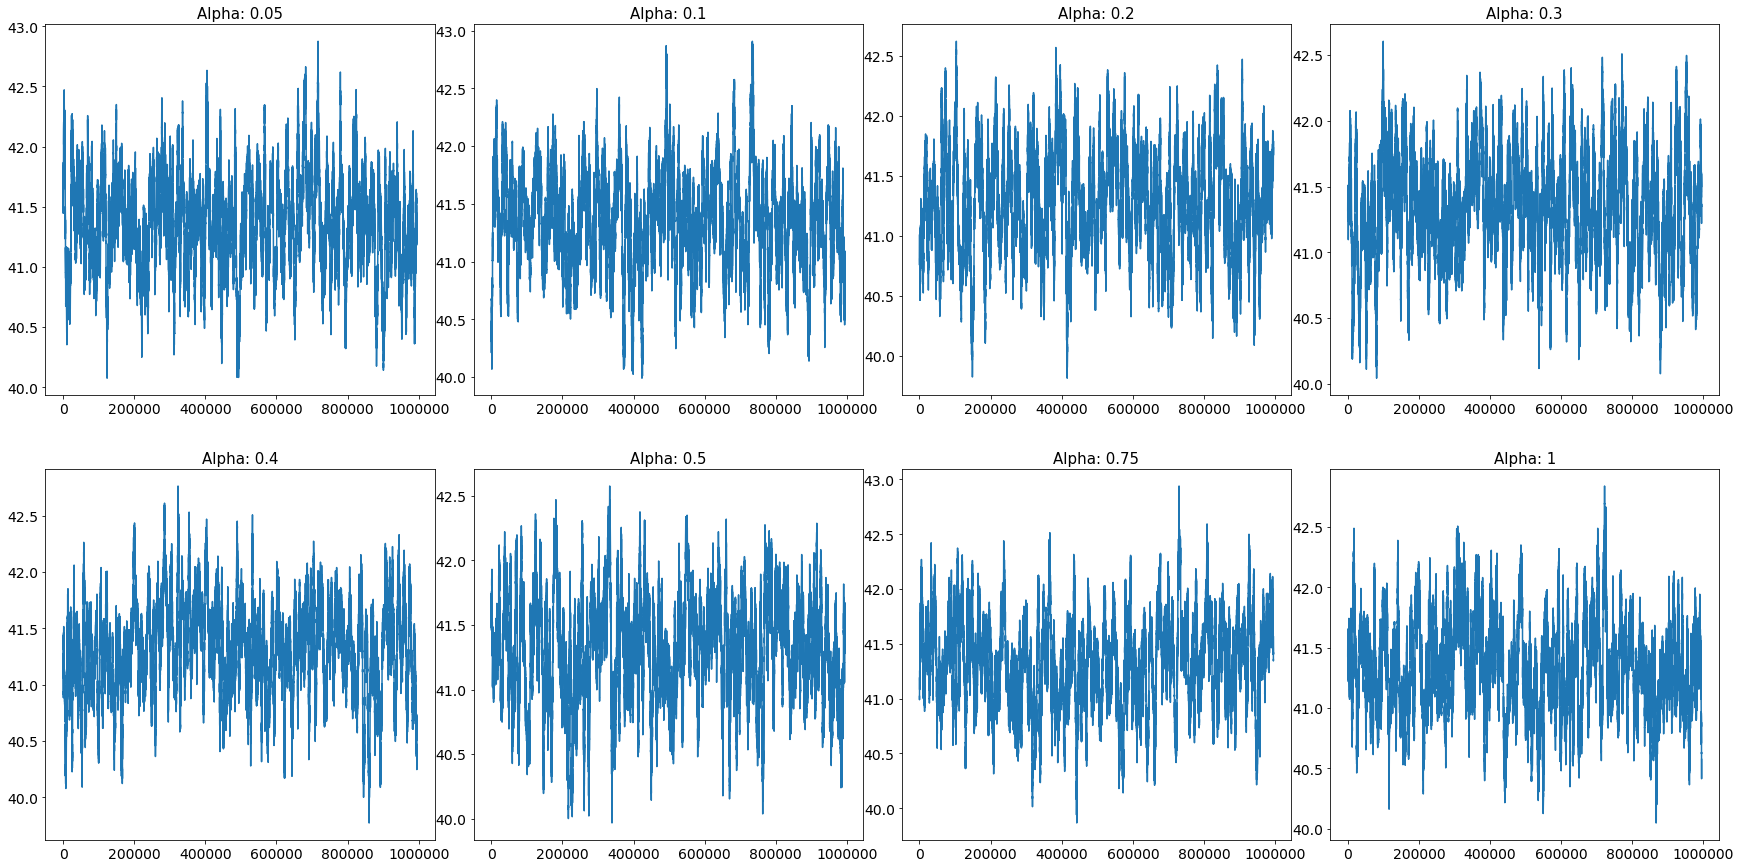

In [33]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
q_learning_sma_rewards = [moving_average(rewards, 5000) for rewards in q_learning_alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(q_learning_alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

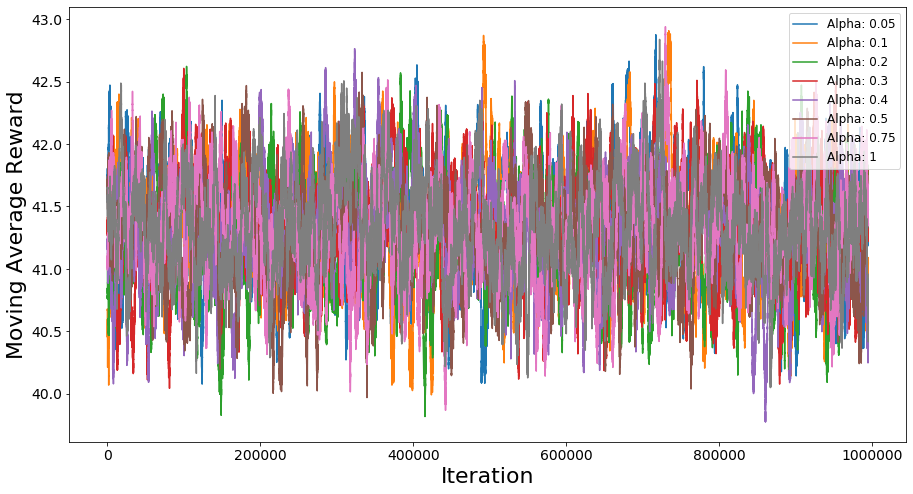

In [34]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(q_learning_sma_rewards)):
    plt.plot(q_learning_sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [37]:
# Choosing algo with highest mean converged reward for the final quarter of actions
q_learning_average_final_rewards = []
for i in range(len(q_learning_alpha_rewards)):
    rewards = q_learning_alpha_rewards[i]
    q_learning_average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
q_learning_optimal_alpha = alpha_range[int(np.argmax(q_learning_average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {optimal_alpha}"
)

Optimal Hyperparameter: 0.75


### Calculating Q-learning over best action

In [69]:
total_iters = 1000000
no_decay_iters = 1000000
decay=True


centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
q_learning_agent = tabular_model_free_agent(
    max_vax=12,
    max_delivery=20,
    alpha=q_learning_optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=QLearning_policy
)
rewards = []
q_learning_visits = np.zeros((13,13))
for i in range(total_iters):
    if (i+1) % 100000 == 0:
        print(f"Alpha: {optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = q_learning_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
    q_learning_visits[next_state[0],next_state[1]] += 1

IndexError: index 14 is out of bounds for axis 1 with size 13

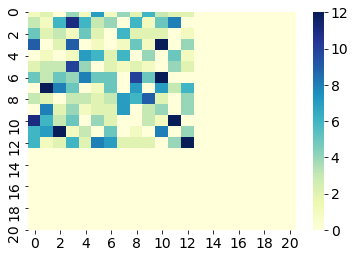

In [66]:
fig = sns.heatmap(
    np.argmax(q_learning_agent.q, axis=-1),
    cmap="YlGnBu",
)

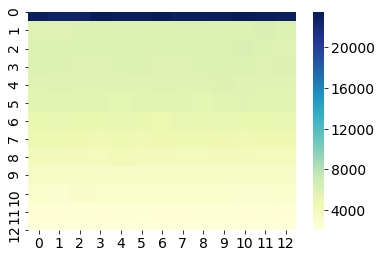

In [67]:
fig = sns.heatmap(
    q_learning_visits,
    cmap="YlGnBu",
)

In [63]:
q_learning_visits

array([[23117., 23149., 23120., 23155., 23115., 23026., 23070., 23256.,
        23108., 23087., 23279., 23194., 23300.],
       [ 5904.,  5862.,  6068.,  5899.,  5867.,  5968.,  5786.,  6042.,
         5940.,  5915.,  5991.,  5797.,  5921.],
       [ 5957.,  5910.,  5928.,  5960.,  5867.,  5830.,  5783.,  5956.,
         5872.,  5968.,  5942.,  5978.,  5914.],
       [ 5932.,  5813.,  5778.,  5885.,  5884.,  5747.,  5692.,  5901.,
         5748.,  5972.,  5890.,  5726.,  5761.],
       [ 5745.,  5598.,  5733.,  5641.,  5738.,  5768.,  5689.,  5804.,
         5687.,  5869.,  5641.,  5727.,  5778.],
       [ 5448.,  5578.,  5452.,  5581.,  5412.,  5323.,  5424.,  5530.,
         5498.,  5383.,  5486.,  5405.,  5400.],
       [ 5175.,  5128.,  4980.,  5151.,  5158.,  5192.,  4938.,  5079.,
         5119.,  5128.,  5062.,  5162.,  5041.],
       [ 4606.,  4633.,  4685.,  4640.,  4709.,  4764.,  4686.,  4598.,
         4628.,  4505.,  4616.,  4594.,  4732.],
       [ 4038.,  4199.,  4138., 

## SARSA

In [47]:
%%time

total_iters = 1000000
no_decay_iters = 200000
decay=True

sarsa_alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
    sarsa_agent = tabular_model_free_agent(
        max_vax=12,
        max_delivery=10,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=sarsa_policy
    )
    rewards = []
#     results = []
    for i in range(total_iters):
        if (i+1) % 100000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    sarsa_alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 500000
Alpha: 0.05. Iteration: 600000
Alpha: 0.05. Iteration: 700000
Alpha: 0.05. Iteration: 800000
Alpha: 0.05. Iteration: 900000
Alpha: 0.05. Iteration: 1000000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 200000
Alpha: 0.1. Iteration: 300000
Alpha: 0.1. Iteration: 400000
Alpha: 0.1. Iteration: 500000
Alpha: 0.1. Iteration: 600000
Alpha: 0.1. Iteration: 700000
Alpha: 0.1. Iteration: 800000
Alpha: 0.1. Iteration: 900000
Alpha: 0.1. Iteration: 1000000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 200000
Alpha: 0.2. Iteration: 300000
Alpha: 0.2. Iteration: 400000
Alpha: 0.2. Iteration: 500000
Alpha: 0.2. Iteration: 600000
Alpha: 0.2. Iteration: 700000
Alpha: 0.2. Iteration: 800000
Alpha: 0.2. Iteration: 900000
Alpha: 0.2. Iterat

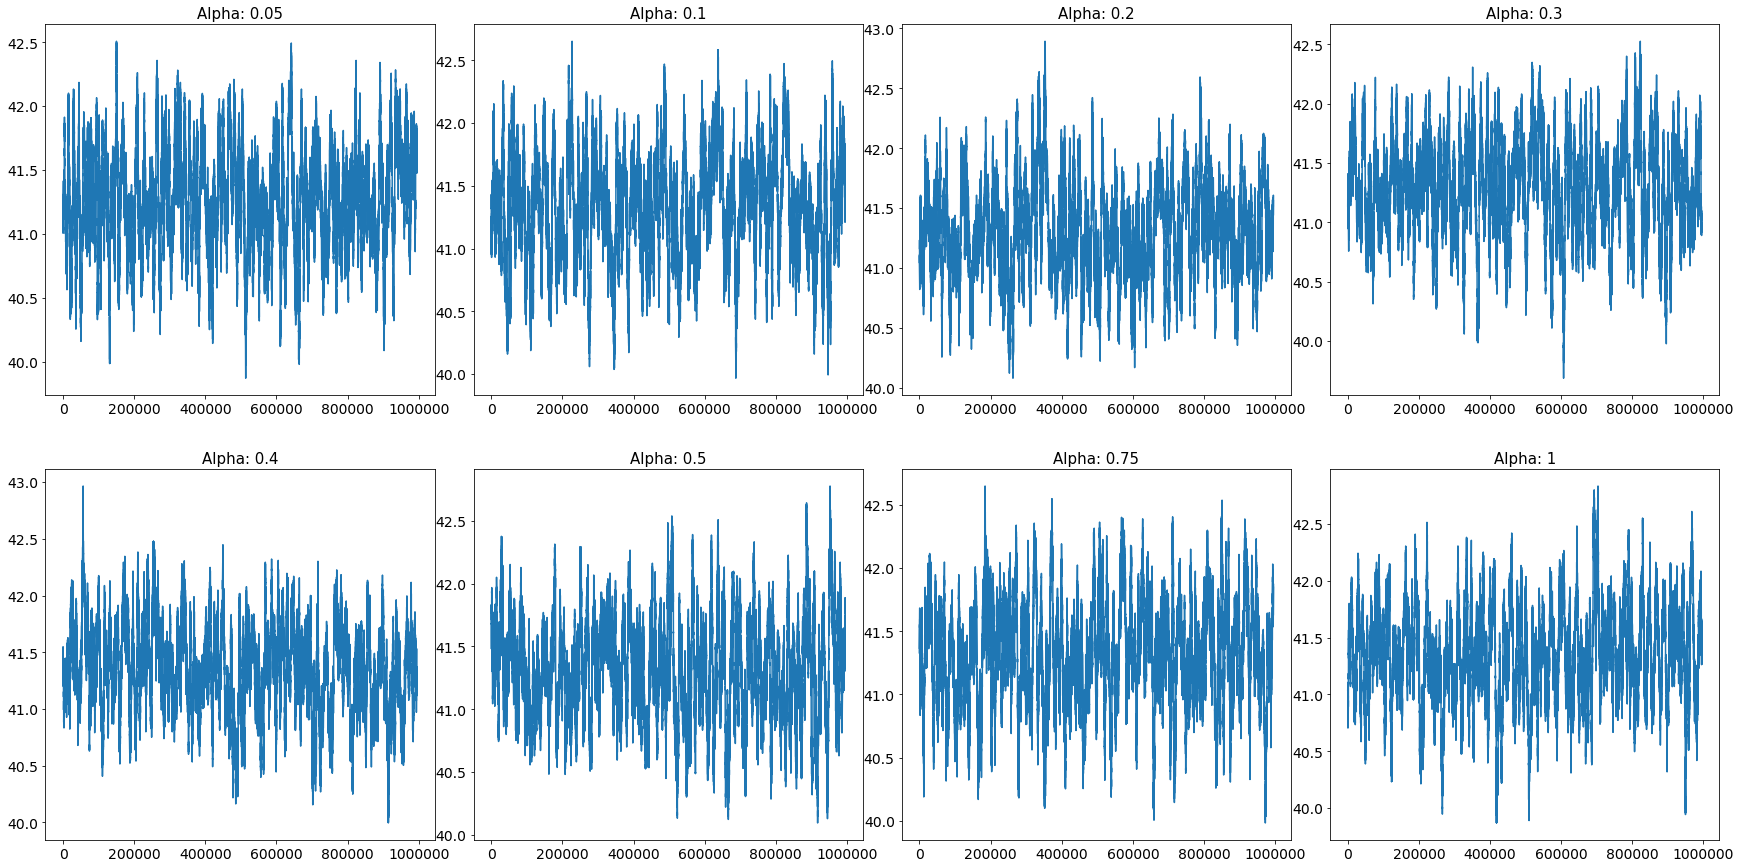

In [48]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
sarsa_sma_rewards = [moving_average(rewards, 5000) for rewards in sarsa_alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(sarsa_alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

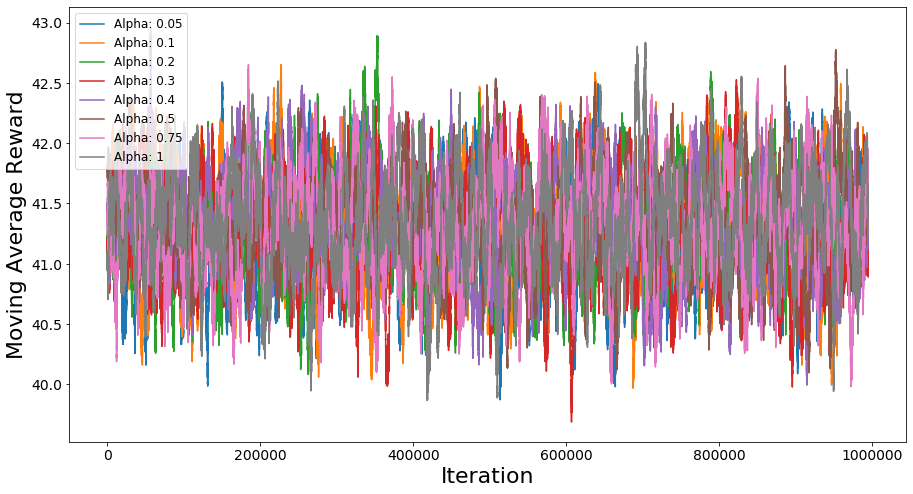

In [49]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(sarsa_sma_rewards)):
    plt.plot(sarsa_sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [50]:
# Choosing algo with highest mean converged reward for the final quarter of actions
sarsa_average_final_rewards = []
for i in range(len(sarsa_alpha_rewards)):
    rewards = sarsa_alpha_rewards[i]
    sarsa_average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
sarsa_optimal_alpha = alpha_range[int(np.argmax(sarsa_average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {optimal_alpha}"
)

Optimal Hyperparameter: 0.75


### Calculating SARSA over best action

In [51]:
total_iters = 1000000
no_decay_iters = 200000
decay=True


centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
sarsa_agent = tabular_model_free_agent(
    max_vax=12,
    max_delivery=12,
    alpha=sarsa_optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=sarsa_policy
)
sarsa_visits = np.zeros((13,13))
rewards = []
for i in range(total_iters):
    if (i+1) % 100000 == 0:
        print(f"Alpha: {optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
    sarsa_visits[next_state[0],next_state[1]] += 1

Alpha: 0.75. Iteration: 100000
Alpha: 0.75. Iteration: 200000
Alpha: 0.75. Iteration: 300000
Alpha: 0.75. Iteration: 400000
Alpha: 0.75. Iteration: 500000
Alpha: 0.75. Iteration: 600000
Alpha: 0.75. Iteration: 700000
Alpha: 0.75. Iteration: 800000
Alpha: 0.75. Iteration: 900000
Alpha: 0.75. Iteration: 1000000


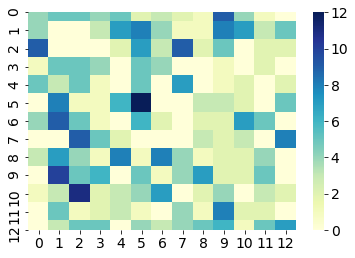

In [52]:
fig = sns.heatmap(
    np.argmax(sarsa_agent.q, axis=-1),
    cmap="YlGnBu",
)

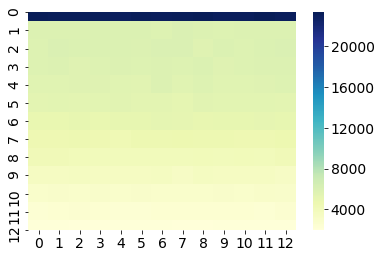

In [53]:
fig = sns.heatmap(
    sarsa_visits,
    cmap="YlGnBu",
)

In [54]:
sarsa_visits

array([[23319., 23218., 23224., 23224., 23053., 23206., 23123., 23160.,
        23242., 23110., 23080., 23282., 23076.],
       [ 5905.,  5881.,  5902.,  5977.,  6000.,  5960.,  5760.,  6011.,
         5841.,  5763.,  5896.,  5890.,  5894.],
       [ 5821.,  6065.,  5963.,  5957.,  5997.,  5882.,  6013.,  6007.,
         5727.,  5937.,  5813.,  5931.,  6024.],
       [ 5824.,  5855.,  5739.,  5767.,  5857.,  5798.,  5850.,  5832.,
         5925.,  5727.,  5817.,  5839.,  5836.],
       [ 5665.,  5624.,  5672.,  5689.,  5654.,  5565.,  5876.,  5590.,
         5753.,  5600.,  5648.,  5688.,  5773.],
       [ 5383.,  5423.,  5392.,  5467.,  5509.,  5392.,  5382.,  5312.,
         5549.,  5486.,  5463.,  5479.,  5409.],
       [ 4986.,  4998.,  5158.,  4962.,  5138.,  5107.,  5261.,  5232.,
         5058.,  5123.,  5112.,  5238.,  5144.],
       [ 4556.,  4579.,  4615.,  4574.,  4475.,  4637.,  4661.,  4698.,
         4616.,  4622.,  4541.,  4583.,  4720.],
       [ 4217.,  4201.,  4124., 

## Expected SARSA

In [19]:
%%time

total_iters = 1000000
no_decay_iters = 200000
decay=True

e_sarsa_alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
    e_sarsa_agent = tabular_model_free_agent(
        max_vax=12,
        max_delivery=10,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=expected_sarsa_policy
    )
    rewards = []
#     results = []
    for i in range(total_iters):
        if (i+1) % 100000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = e_sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    e_sarsa_alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 500000
Alpha: 0.05. Iteration: 600000
Alpha: 0.05. Iteration: 700000
Alpha: 0.05. Iteration: 800000
Alpha: 0.05. Iteration: 900000
Alpha: 0.05. Iteration: 1000000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 200000
Alpha: 0.1. Iteration: 300000
Alpha: 0.1. Iteration: 400000
Alpha: 0.1. Iteration: 500000
Alpha: 0.1. Iteration: 600000
Alpha: 0.1. Iteration: 700000
Alpha: 0.1. Iteration: 800000
Alpha: 0.1. Iteration: 900000
Alpha: 0.1. Iteration: 1000000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 200000
Alpha: 0.2. Iteration: 300000
Alpha: 0.2. Iteration: 400000
Alpha: 0.2. Iteration: 500000
Alpha: 0.2. Iteration: 600000
Alpha: 0.2. Iteration: 700000
Alpha: 0.2. Iteration: 800000
Alpha: 0.2. Iteration: 900000
Alpha: 0.2. Iterat

/home/davide/RL_projects/vaccine/RL-Exploration/vaccine_delivery/agents.py:128: RuntimeWarning: overflow encountered in double_scalars
  ] += self.alpha * delta
/home/davide/RL_projects/vaccine/RL-Exploration/vaccine_delivery/agents.py:122: RuntimeWarning: invalid value encountered in double_scalars
  ) - self.q[old_vaccines, new_vaccines, next_action]


Alpha: 0.75. Iteration: 900000
Alpha: 0.75. Iteration: 1000000
######## Alpha: 1 ############
Alpha: 1. Iteration: 100000
Alpha: 1. Iteration: 200000
Alpha: 1. Iteration: 300000
Alpha: 1. Iteration: 400000
Alpha: 1. Iteration: 500000
Alpha: 1. Iteration: 600000
Alpha: 1. Iteration: 700000
Alpha: 1. Iteration: 800000
Alpha: 1. Iteration: 900000
Alpha: 1. Iteration: 1000000
CPU times: user 6min 39s, sys: 4.18 s, total: 6min 43s
Wall time: 6min 39s


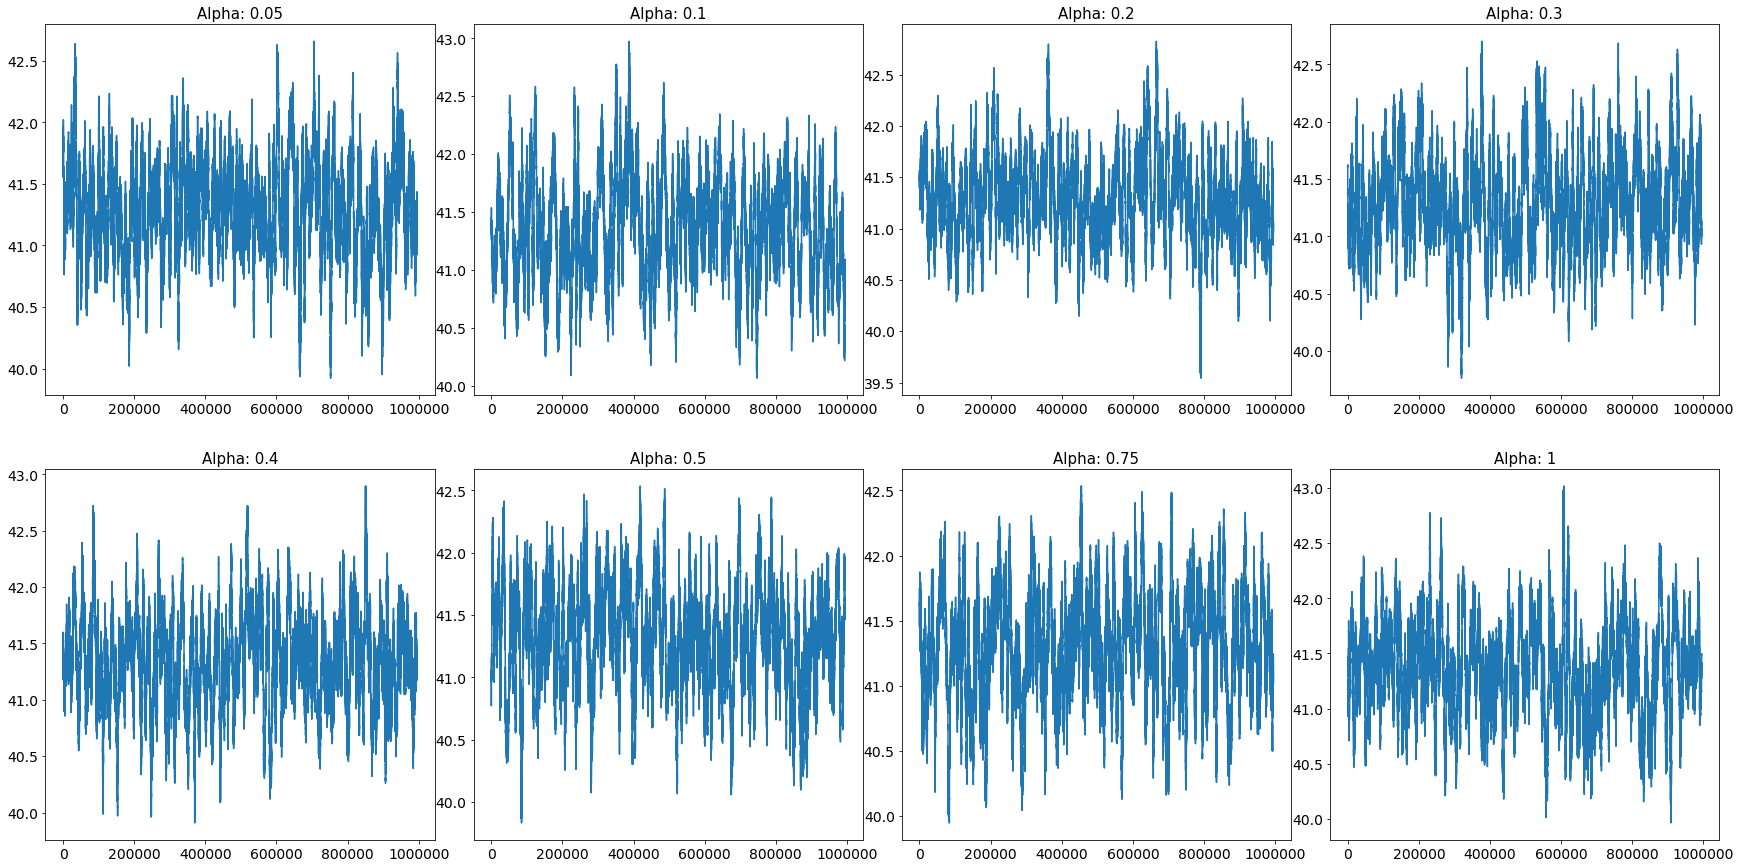

In [20]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
e_sarsa_sma_rewards = [moving_average(rewards, 5000) for rewards in e_sarsa_alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(e_sarsa_alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

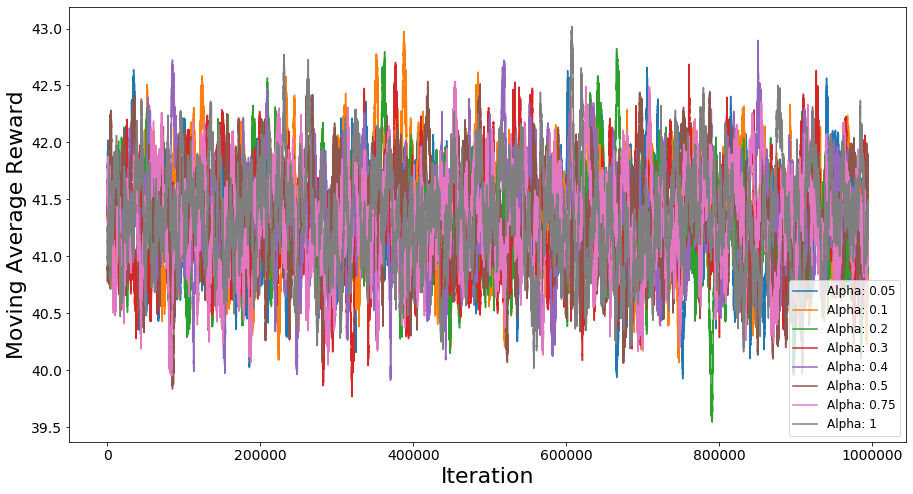

In [22]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(e_sarsa_sma_rewards)):
    plt.plot(e_sarsa_sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [24]:
# Choosing algo with highest mean converged reward for the final quarter of actions
e_sarsa_average_final_rewards = []
for i in range(len(e_sarsa_alpha_rewards)):
    rewards = e_sarsa_alpha_rewards[i]
    e_sarsa_average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
optimal_alpha = alpha_range[int(np.argmax(e_sarsa_average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {optimal_alpha}"
)

Optimal Hyperparameter: 1


### Calculating Expected SARSA over best action

In [25]:
total_iters = 1000000
no_decay_iters = 200000
decay=True


centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
e_sarsa_agent = tabular_model_free_agent(
    max_vax=12,
    max_delivery=12,
    alpha=optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=expected_sarsa_policy
)
rewards = []
for i in range(total_iters):
    if (i+1) % 100000 == 0:
        print(f"Alpha: {optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = e_sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)

Alpha: 1. Iteration: 100000
Alpha: 1. Iteration: 200000
Alpha: 1. Iteration: 300000
Alpha: 1. Iteration: 400000
Alpha: 1. Iteration: 500000
Alpha: 1. Iteration: 600000
Alpha: 1. Iteration: 700000
Alpha: 1. Iteration: 800000
Alpha: 1. Iteration: 900000
Alpha: 1. Iteration: 1000000


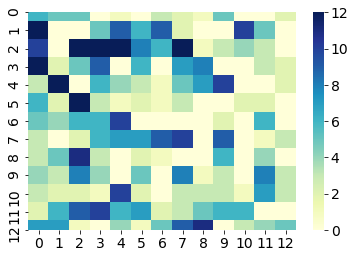

In [26]:
fig = sns.heatmap(
    np.argmax(e_sarsa_agent.q, axis=-1),
    cmap="YlGnBu",
)